In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

## LOADING DATA

In [2]:
file_ddp = '../benchmark_master_results_for_ddp_backup.csv'
file_fsdp = '../fsdp_benchmark_metrics.csv'

## PREPROCESSING & MERGING

In [5]:
df_ddp = pd.read_csv(file_ddp)
df_fsdp = pd.read_csv(file_fsdp)

# Adding 'Strategy' column
df_ddp['Strategy'] = 'DDP'
df_fsdp['Strategy'] = 'FSDP'

# Ensuring columns match for merging
common_cols = ['gpu_count', 'batch_size', 'epoch', 'train_acc', 'val_acc', 'train_loss', 'val_loss', 'epoch_time', 'Strategy']

# Create the Combined DataFrame
df_combined = pd.concat([df_ddp[common_cols], df_fsdp[common_cols]], ignore_index=True)

# --- AGGREGATE METRICS (Per Config) ---
# We want one row per (Strategy, GPU, Batch)
summary = df_combined.groupby(['Strategy', 'gpu_count', 'batch_size']).agg({
    'epoch_time': 'sum',      # Total Training Time
    'val_acc': 'max',         # Best Validation Accuracy
    'train_loss': 'min'       # Best Training Loss
}).reset_index()

# Rename for clarity
summary.rename(columns={'epoch_time': 'Total Time (s)', 'val_acc': 'Best Accuracy'}, inplace=True)

# Calculate Throughput (Images/Sec)
# Approx: (Total Images * Epochs) / Total Time
# Assuming standard dataset size ~240k images (Train+Val)
# Or simplified: Speedup Factor relative to 1 GPU

print(summary)

   Strategy  gpu_count  batch_size  Total Time (s)  Best Accuracy  train_loss
0       DDP          1          64     3092.302017       0.936152    0.166122
1       DDP          1         128     3248.208545       0.931330    0.183869
2       DDP          1         512     3344.022161       0.909091    0.234518
3       DDP          2          64     1651.706201       0.928919    0.191773
4       DDP          2         128     1591.813689       0.902877    0.359947
5       DDP          2         512     1613.187841       0.898969    0.258265
6       DDP          4          64      828.813915       0.916868    0.210743
7       DDP          4         128      812.263965       0.908263    0.235173
8       DDP          4         512      806.101204       0.881786    0.288461
9      FSDP          1          64     3231.818564       0.940974    0.163767
10     FSDP          1         128     3245.414447       0.924949    0.195442
11     FSDP          1         512     3278.752577       0.90913

## VISUALIZATION

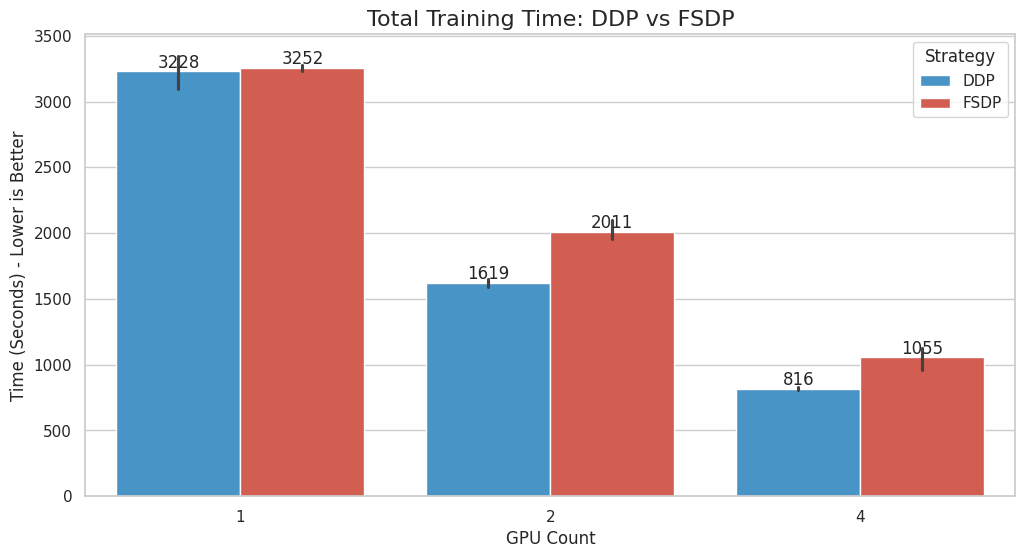

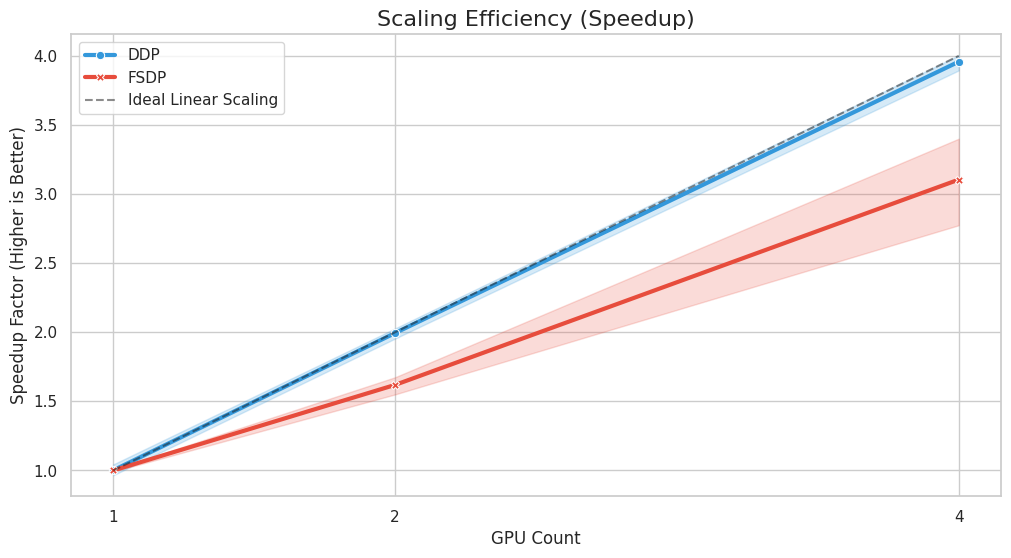

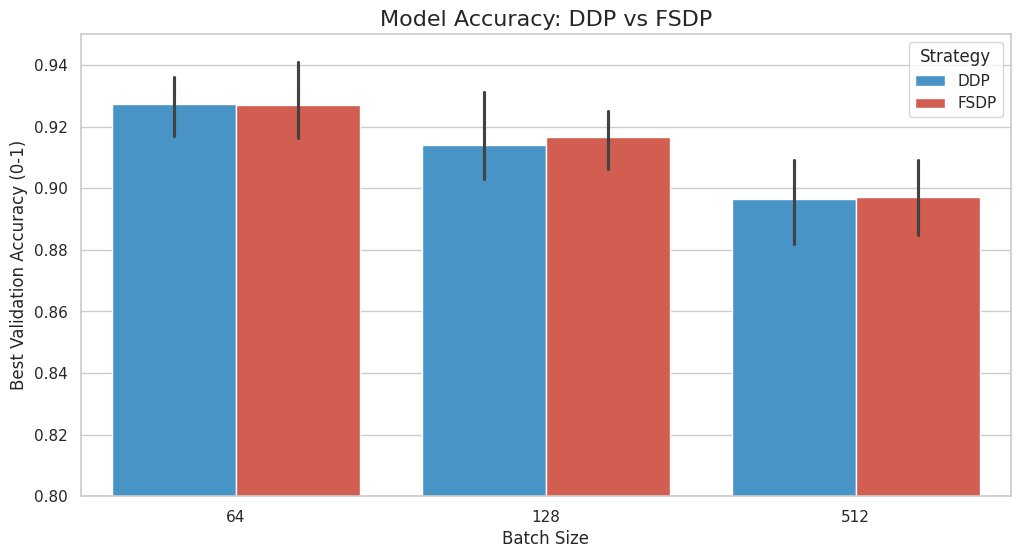

In [8]:
sns.set_theme(style="whitegrid")

# TOTAL TRAINING TIME
plt.figure(figsize=(12, 6))
ax1 = sns.barplot(
    data=summary, 
    x='gpu_count', 
    y='Total Time (s)', 
    hue='Strategy',
    palette={'DDP': '#3498db', 'FSDP': '#e74c3c'}
)
plt.title('Total Training Time: DDP vs FSDP', fontsize=16)
plt.xlabel('GPU Count', fontsize=12)
plt.ylabel('Time (Seconds) - Lower is Better', fontsize=12)
plt.legend(title='Strategy')

# Adding labels
for container in ax1.containers:
    ax1.bar_label(container, fmt='%.0f')
plt.show()

# SCALING EFFICIENCY (Speedup)
# Calculating Speedup relative to 1 GPU for each strategy
summary['Speedup'] = 0.0
for strat in ['DDP', 'FSDP']:
    base_time = summary[(summary['Strategy'] == strat) & (summary['gpu_count'] == 1)]['Total Time (s)'].mean()
    summary.loc[summary['Strategy'] == strat, 'Speedup'] = base_time / summary['Total Time (s)']

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=summary, 
    x='gpu_count', 
    y='Speedup', 
    hue='Strategy', 
    style='Strategy',
    markers=True, 
    dashes=False,
    linewidth=3,
    palette={'DDP': '#3498db', 'FSDP': '#e74c3c'}
)
plt.plot([1, 4], [1, 4], 'k--', label='Ideal Linear Scaling', alpha=0.5) # Reference Line
plt.title('Scaling Efficiency (Speedup)', fontsize=16)
plt.xlabel('GPU Count', fontsize=12)
plt.ylabel('Speedup Factor (Higher is Better)', fontsize=12)
plt.legend()
plt.xticks(summary['gpu_count'].unique())
plt.show()

# ACCURACY COMPARISON 
plt.figure(figsize=(12, 6))
ax3 = sns.barplot(
    data=summary, 
    x='batch_size', 
    y='Best Accuracy', 
    hue='Strategy',
    palette={'DDP': '#3498db', 'FSDP': '#e74c3c'}
)
plt.title('Model Accuracy: DDP vs FSDP', fontsize=16)
plt.xlabel('Batch Size', fontsize=12)
plt.ylabel('Best Validation Accuracy (0-1)', fontsize=12)
plt.ylim(0.8, 0.95)
plt.legend(title='Strategy')
plt.show()

## FINAL VERDICT TABLE

In [7]:
pivot_table = summary.pivot_table(
        index=['gpu_count', 'batch_size'], 
        columns='Strategy', 
        values='Total Time (s)'
    )
pivot_table['Diff (s)'] = pivot_table['DDP'] - pivot_table['FSDP']
pivot_table['Winner'] = pivot_table.apply(lambda x: 'FSDP' if x['FSDP'] < x['DDP'] else 'DDP', axis=1)

print("\nHead-to-Head Comparison (Training Time):")
print("-" * 60)
print(pivot_table)


Head-to-Head Comparison (Training Time):
------------------------------------------------------------
Strategy                      DDP         FSDP    Diff (s) Winner
gpu_count batch_size                                             
1         64          3092.302017  3231.818564 -139.516547    DDP
          128         3248.208545  3245.414447    2.794098   FSDP
          512         3344.022161  3278.752577   65.269584   FSDP
2         64          1651.706201  2097.497301 -445.791100    DDP
          128         1591.813689  1992.022625 -400.208935    DDP
          512         1613.187841  1942.033705 -328.845864    DDP
4         64           828.813915  1172.057116 -343.243201    DDP
          128          812.263965  1036.121029 -223.857064    DDP
          512          806.101204   956.250574 -150.149370    DDP
